In [1]:
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture import BayesianGaussianMixture as BGMM
import warnings
import seaborn as sns
#import pygmmis
from my_gmm import my_GMM, estimate_MI_single_posterior_sample, consistent, bootstrap_multiprocessing
#from multiprocess import set_start_method
# https://pythonspeed.com/articles/python-multiprocessing/
#set_start_method("fork") # 'fork' seems to get deadlocked, 'spawn' is a bit slower but works
#from multiprocess import Pool
from functools import partial
from sklearn.feature_selection import mutual_info_regression
import gc
import time
from scipy.stats import multivariate_normal
from scipy.stats import chi2 as chisquare

from matplotlib.patches import Ellipse
import pandas as pd

from sklearn.utils import check_random_state
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

import pygmmis

In [34]:
def calc_entropy(n_comp, best_w, best_m, best_c):
    best_fitted_GMM = my_GMM(n_components=n_comp, weights=best_w, means=best_m, covariances=best_c, random_state=0)
    integral_samples = best_fitted_GMM.sample(1e6)[0]

    log_values = best_fitted_GMM.score_samples(integral_samples)
    best_mean_value = log_values.mean()
    best_var_value = (log_values**2).mean()
    best_var_value = best_var_value - best_mean_value**2
    best_mean_value *= ds_size
    best_var_value *=  ds_size
    best_stddev_value = np.sqrt(best_var_value)
    
    return best_mean_value, best_stddev_value

def draw_ellipse(position, covariance, weight, ax=None, alpha=None, color=None, label=None, count=0, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        #print(s)
        
    # Draw the Ellipse
    # These should be 68% and 95% contours, from a chi2 table
    ranges = [np.sqrt(5.991)] #[np.sqrt(0.77), np.sqrt(5.991)]
    for nsig in ranges:
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, color=color, alpha=alpha, **kwargs))
    ax.scatter(position[0], position[1],  marker='X', s=2000*weight, color=color, alpha=alpha, label=label if count==0 else "")
    ax.legend(fontsize=20, frameon=False)
        
def plot_covariance(means_fitted, covariances_fitted, weights_fitted, ax=None):
    ax = ax or plt.gca()
    ax.set_xlim((-4, 4))
    ax.set_ylim((-1.5, 4))
    
    w_factor = 0.5 # just for the plot
    count=0
    for mean_fitted, covariance_fitted, weight_fitted in zip(means_fitted, covariances_fitted, weights_fitted):
        draw_ellipse(mean_fitted, covariance_fitted, weight_fitted, ax=ax, alpha=w_factor, fill=False, color='red', linewidth=3, label='Fitted', count=count)
        count += 1

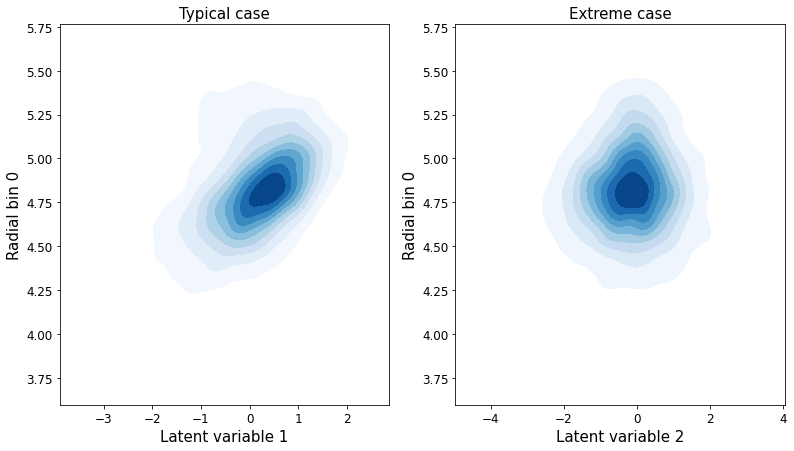

In [3]:
truth = np.load("./true_log_rho_per_radial_bin_sim11_testset.npy")

lmean, lstd = np.load("./latent_mean_11_testset_epoch_46.npy"), np.load("./latent_std_11_testset_epoch_46.npy")

samples = np.random.normal(lmean[:, 0], lstd[:, 0], len(lmean[:, 2]))
samples_ = np.random.normal(lmean[:, 1], lstd[:, 1], len(lmean[:, 1]))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13, 7))
sns.kdeplot(ax=ax1, x=samples_, y=truth[3], cmap="Blues", shade=True)
ax1.set_xlabel('Latent variable 1', fontsize=15)
ax1.set_ylabel('Radial bin 0', fontsize=15)
ax1.set_title('Typical case', fontsize=15)
ax1.tick_params(axis='both', which='major', labelsize=12)
sns.kdeplot(ax=ax2, x=samples, y=truth[3], cmap="Blues", shade=True)
ax2.set_xlabel('Latent variable 2', fontsize=15)
ax2.set_ylabel('Radial bin 0', fontsize=15)
ax2.set_title('Extreme case', fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=12);

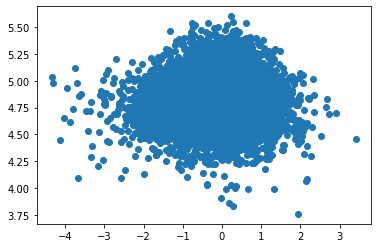

In [4]:
plt.scatter(x=samples, y=truth[3])

### Procedure: we loop over k components. Do 4-fold CV over N=1e4 samples, doing 10 inits each time. Pick the highest validation loss. Plot val loss as a function of k. Also check for optimality. Then select best model, and calculate MI for both best model and one with one more component.

In [16]:
x = np.copy(samples)
y = np.copy(truth[3])
X = np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), axis=1)[:-1] # remove one point so that we can divide in 3

In [27]:
from sklearn.model_selection import train_test_split 

X_fit, X_eval = train_test_split( X, test_size=0.6666, random_state=42 )

X_fit1, X_fit2 = train_test_split( X_eval, test_size=0.50, random_state=43 )

In [28]:
X_fit.shape, X_fit.shape, X_fit2.shape

((2014, 2), (2014, 2), (2014, 2))

In [29]:
n_inits = 10
n_datasets = 3
ds_size = X_fit.shape[0]
#N = n_datasets*ds_size
tol = 1e-6
reg_covar = 1e-6
n_components_loop = 7
val_losses = np.zeros(( n_components_loop, 2 ))
goodness_flags = np.zeros(n_components_loop)

X_all = np.zeros((n_datasets, ds_size, 2))

# first, sample training and validation data
# this is a mixture of training and validation, since we do m-fold CV
for i in range(n_datasets):
    if i == 0:
        X_all[i] = X_fit
    elif i ==1:
        X_all[i] = X_fit1        
    else:
        X_all[i] = X_fit2
        
for k in range(n_components_loop):
    best_validation_score = -np.inf

    for dataset in range(n_datasets):

        X_training = X_all[dataset].reshape(ds_size, 2) 
        X_validation = X_all[np.arange(len(X_all))!=dataset].reshape(n_datasets-1, ds_size, 2)#X_all[dataset*ds_size:(dataset+1)*ds_size]#X_all[mask]

        for r, init in enumerate(range(n_inits)):
            validation_scores = []
            fitted_gmm = GMM(n_components=k+1, reg_covar=reg_covar, 
                             init_params='kmeans', tol=tol, max_iter=10000, 
                             random_state=r+dataset).fit(X_training)
            # evaluate each fitted model on validation data
            for j in range(n_datasets-1):
                val_score = fitted_gmm.score_samples(X_validation[j].reshape(ds_size, 2)).sum()
                validation_scores.append(np.copy(val_score))

            val_score_mu, val_score_std = np.mean(validation_scores), np.std(validation_scores)

            # check if current validation loss is highest
            if val_score_mu > best_validation_score:
                print('Found higher validation score')
                best_validation_score = val_score_mu
                best_validation_score_std = val_score_std
                # save current model
                best_w, best_m, best_c = np.copy(fitted_gmm.weights_), np.copy(fitted_gmm.means_), np.copy(fitted_gmm.covariances_)
    
    # check that best model is good enough for the current component
    entropy_mu, entropy_std = calc_entropy(k+1,  best_w, best_m, best_c)
    optim_flag = consistent(best_validation_score, entropy_mu, best_validation_score_std, entropy_std)
    
    # need to save current val_score mu and std, and whether this was a good model or not
    val_losses[k] = np.array([best_validation_score, best_validation_score_std])
    goodness_flags[k] = optim_flag
    
    # check if we need to break to calculate 

Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found higher validation score
Found high

In [30]:
goodness_flags

array([1., 1., 1., 1., 1., 1., 1.])

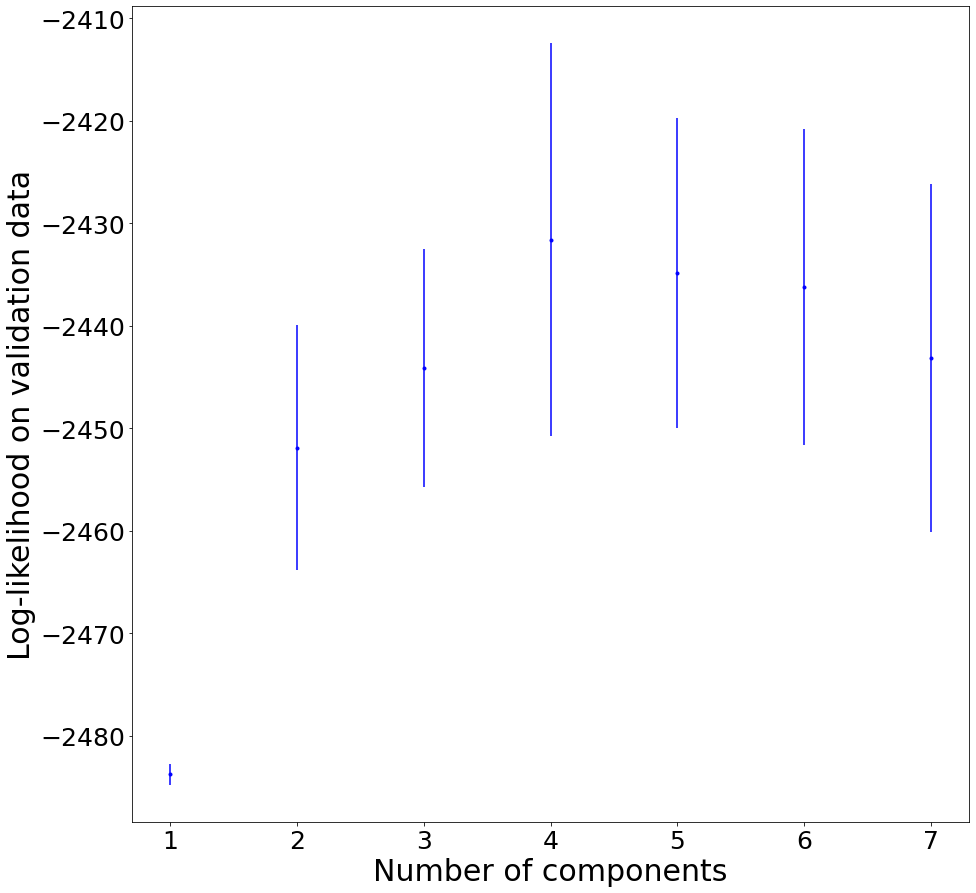

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.errorbar(np.arange(n_components_loop)+1, val_losses[:, 0], val_losses[:, 1], fmt='.', color='b')

ax.set_xticks(np.arange(n_components_loop)+1)
ax.set_xticklabels(np.arange(n_components_loop)+1)

ax.set_xlabel('Number of components', fontsize=30)
ax.set_ylabel('Log-likelihood on validation data', fontsize=30)

ax.tick_params(axis='both', which='major', labelsize=25)

In [22]:
val_losses[6]

array([-2417.12901616,     5.73802636])

In [23]:
val_losses[5]

array([-2414.65310004,     4.85470563])

In [24]:
val_losses[4]

array([-2411.07056612,     4.73771452])

In [25]:
val_losses[3]

array([-2414.16749868,     2.9190603 ])

In [26]:
consistent(val_losses[5][0], val_losses[4][0], val_losses[5][1], val_losses[4][1])

True

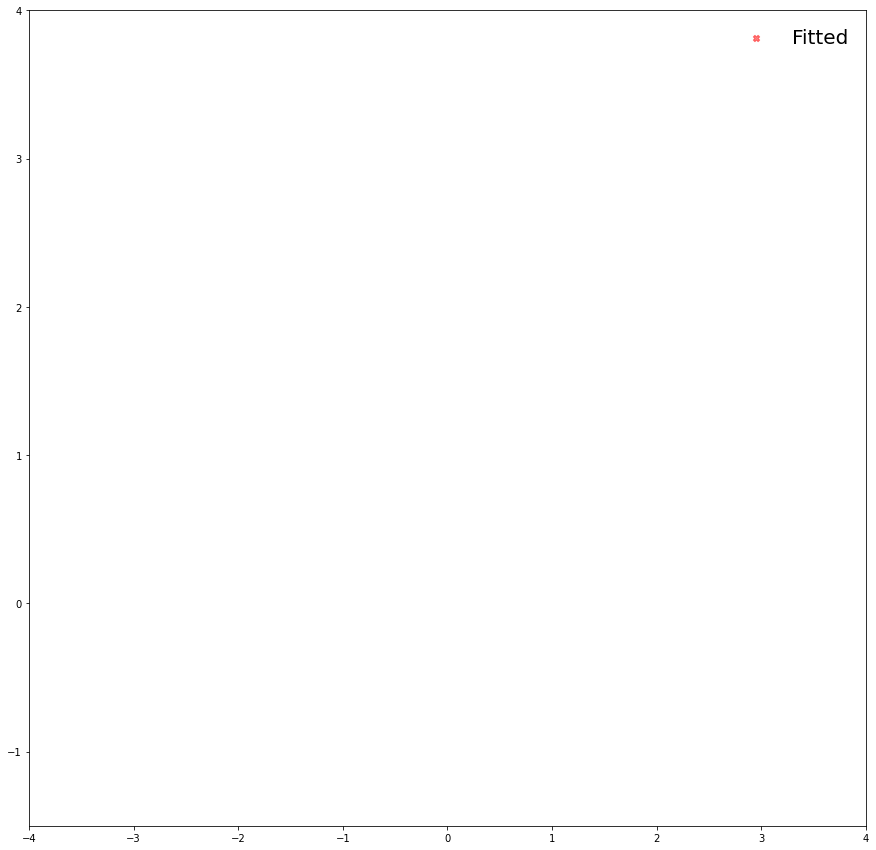

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

plot_covariance(best_m, best_c, best_w, ax=ax)